In [1]:
import pandas as pd
import numpy as np
import datetime
import sqlite3

import requests
import json

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error
%matplotlib inline

In [2]:
df = pd.read_csv('San Rafael Commons_intervals_3216120107.csv')
df.columns

Index(['meter_uid', 'utility', 'utility_service_id', 'utility_service_address',
       'utility_meter_number', 'utility_tariff_name', 'interval_start',
       'interval_end', 'interval_kWh', 'net_kWh', 'source', 'updated',
       'interval_timezone'],
      dtype='object')

In [3]:
dfe = df[['interval_start',
       'interval_end', 'interval_kWh']]

In [4]:
dfe['interval_start'] = pd.to_datetime(dfe['interval_start'],infer_datetime_format=True)

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [5]:
dfe['weekday'] = dfe['interval_start'].apply(lambda x: x.dayofweek)

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
min(dfe.interval_start), max(dfe.interval_start)

(Timestamp('2019-07-30 00:00:00'), Timestamp('2021-08-08 23:45:00'))

In [7]:
dfe.head()

,interval_start,interval_end,interval_kWh,weekday
0,2021-08-08 23:45:00,08/09/2021 00:00,2.00,6
1,2021-08-08 23:30:00,08/08/2021 23:45,2.08,6
2,2021-08-08 23:15:00,08/08/2021 23:30,2.24,6
3,2021-08-08 23:00:00,08/08/2021 23:15,2.16,6
4,2021-08-08 22:45:00,08/08/2021 23:00,2.24,6


In [8]:
dfe['date'] = dfe['interval_start'].dt.date
dfe['hour'] = dfe['interval_start'].dt.hour
dfe['start'] = dfe['interval_start'].dt.time
dfe_hour = pd.DataFrame(dfe.groupby(['date','hour'])['interval_kWh'].sum()).reset_index()
dfe_hour['weekday'] = pd.to_datetime(dfe_hour['date']).apply(lambda x: x.dayofweek)
dfe_hour.head()

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,date,hour,interval_kWh,weekday
0,2019-07-30,0,8.08,1
1,2019-07-30,1,7.84,1
2,2019-07-30,2,7.76,1
3,2019-07-30,3,7.84,1
4,2019-07-30,4,7.76,1


In [9]:
dfe_hour.weekday.unique()

array([1, 2, 3, 4, 5, 6, 0], dtype=int64)

In [10]:
dfe_hour['hour'] = pd.to_timedelta(dfe_hour['hour'], unit='h')
dfe_hour['date'] = pd.to_datetime(dfe_hour['date'])

In [11]:
dfe_hour['timestamp'] = dfe_hour['date'] + dfe_hour['hour']

In [12]:
# Day of the week by hour goups
hours_group = pd.DataFrame(dfe_hour.groupby(['weekday', 'hour'])['interval_kWh'].agg([np.std, 'mean'])).reset_index()
hours_group['days'] = hours_group['weekday'].map({0:'Monday', 
                1:'Tuesday', 2:'Wednesday', 3:'Thursday', 
                    4:'Friday', 5:'Saturday', 6:'Sunday'})

In [13]:
# Day of week by time interval
days_group = pd.DataFrame(dfe.groupby(['weekday', 'start'])['interval_kWh'].agg([np.std, 'mean'])).reset_index()

In [14]:
days_group['days'] = days_group['weekday'].map({0:'Monday', 
                1:'Tuesday', 2:'Wednesday', 3:'Thursday', 
                    4:'Friday', 5:'Saturday', 6:'Sunday'})

## Visualizations

### Day of week by 15 minutes interval

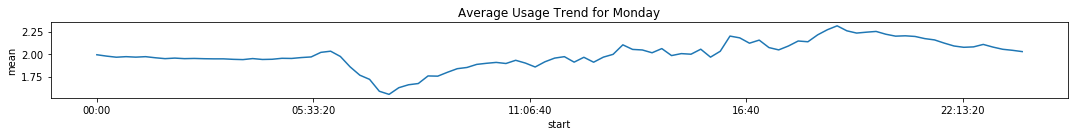

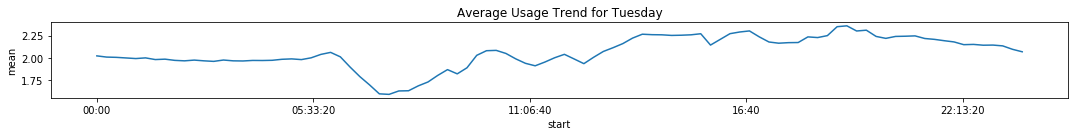

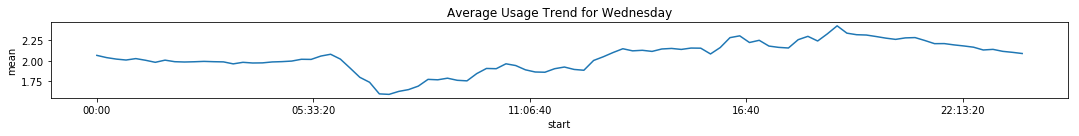

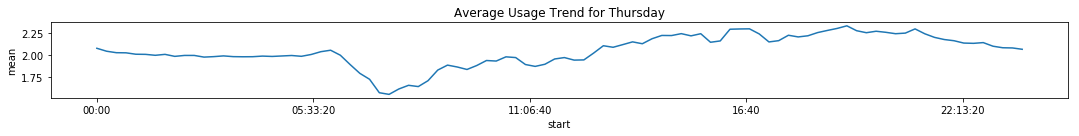

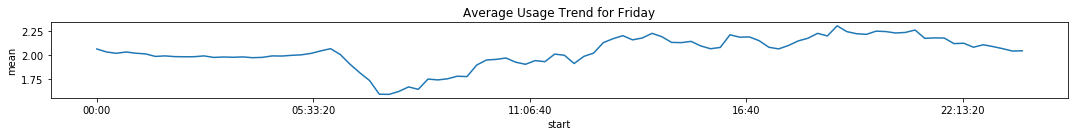

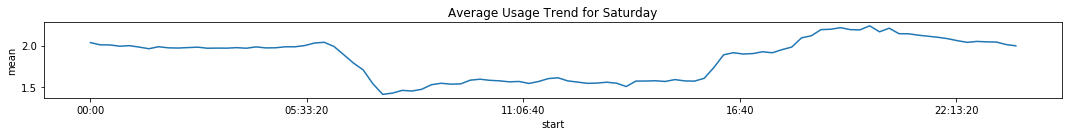

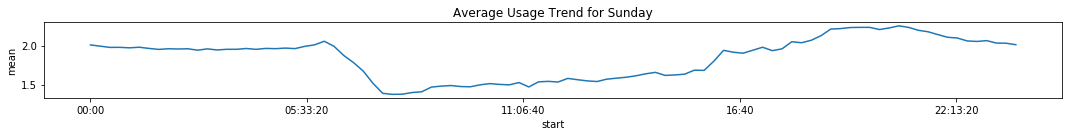

In [15]:
days = ['Monday','Tuesday', 'Wednesday','Thursday', 
        'Friday','Saturday','Sunday']

for day in days:
    fig, ax = plt.subplots(1,1, figsize=(15, 2))
    sns.lineplot(days_group[days_group['days']==day]['start'], 
                 days_group[days_group['days']==day]['mean'])
    plt.title('Average Usage Trend for {}'.format(day))
    plt.tight_layout()

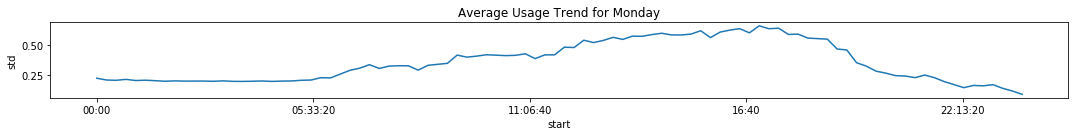

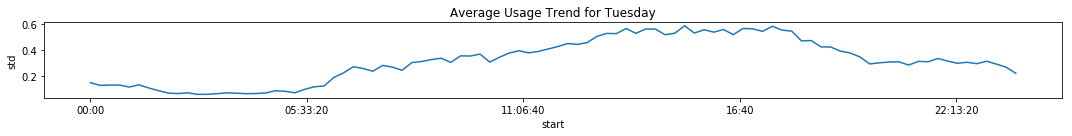

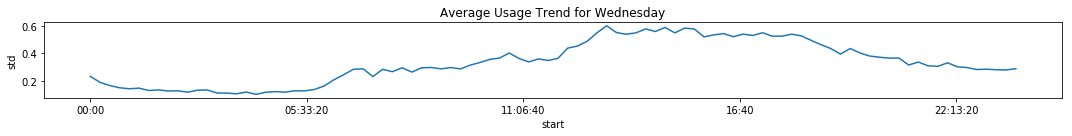

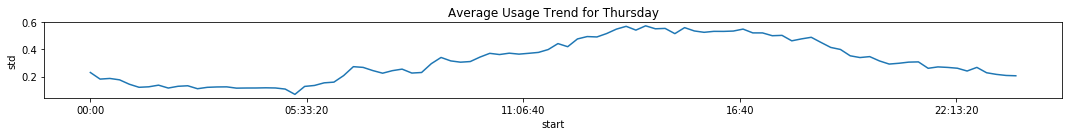

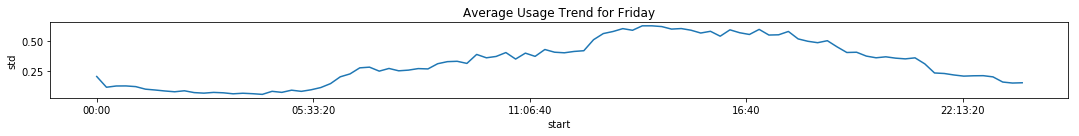

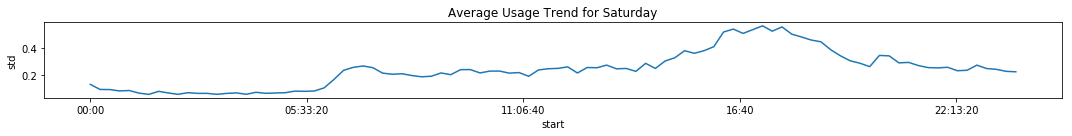

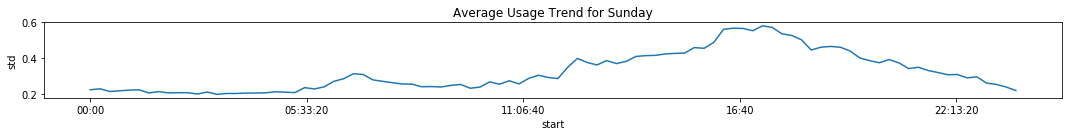

In [16]:
for day in days:
    fig, ax = plt.subplots(1,1, figsize=(15, 2))
    sns.lineplot(days_group[days_group['days']==day]['start'], 
                 days_group[days_group['days']==day]['std'])
    plt.title('Average Usage Trend for {}'.format(day))
    plt.tight_layout()

### Day of week by hour interval

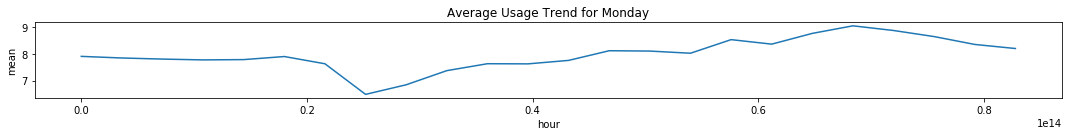

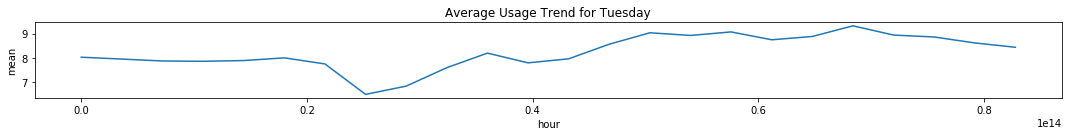

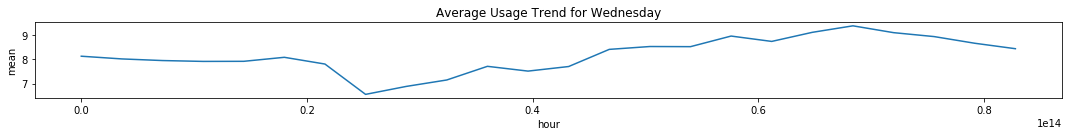

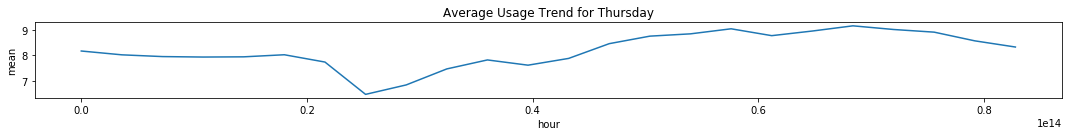

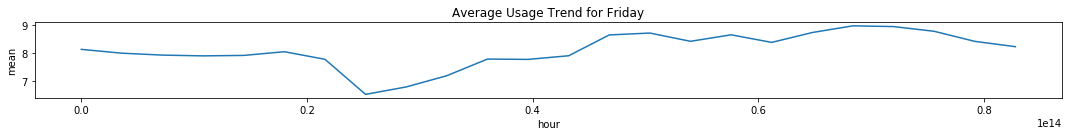

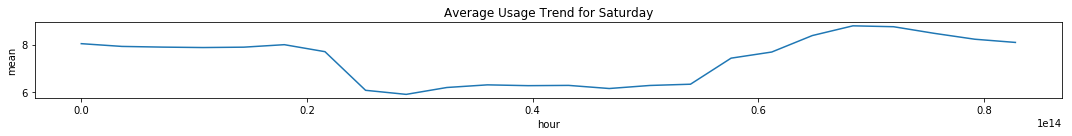

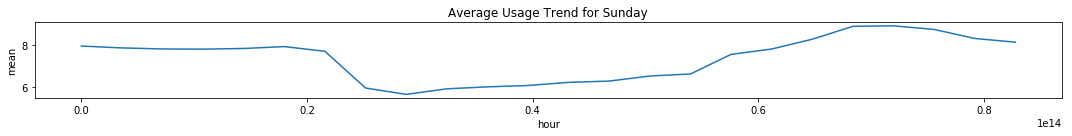

In [17]:
for day in days:
    fig, ax = plt.subplots(1,1, figsize=(15, 2))
    sns.lineplot(hours_group[hours_group['days']==day]['hour'], 
                 hours_group[hours_group['days']==day]['mean'])
    plt.title('Average Usage Trend for {}'.format(day))
    plt.tight_layout()

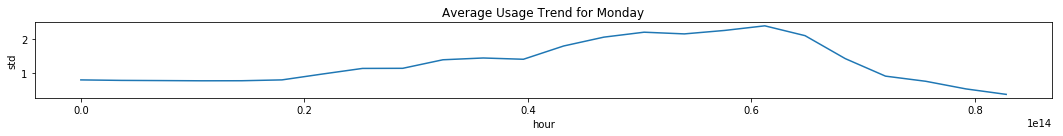

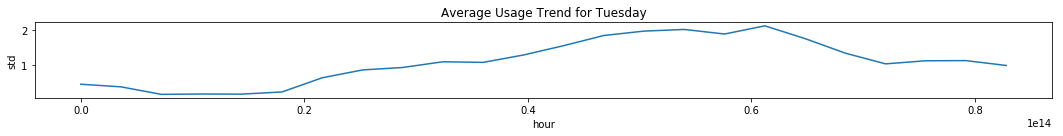

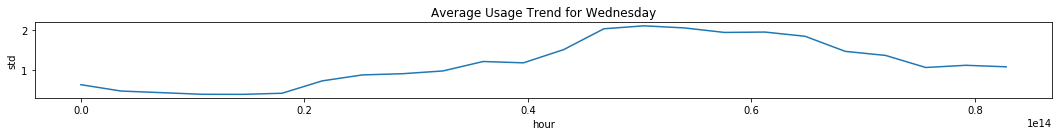

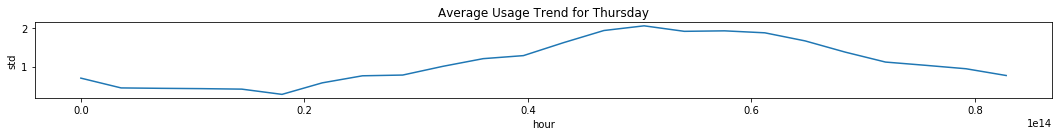

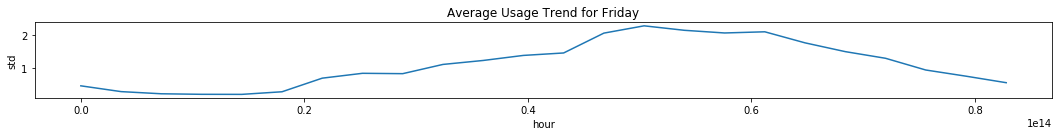

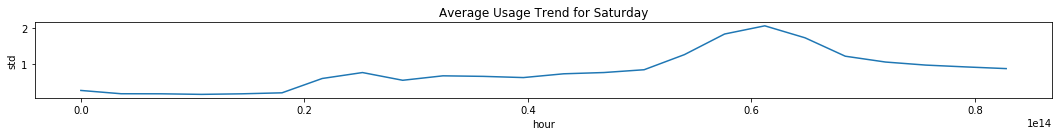

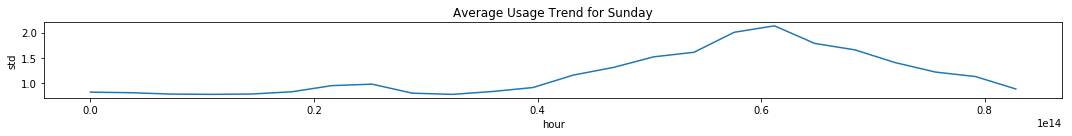

In [18]:
for day in days:
    fig, ax = plt.subplots(1,1, figsize=(15, 2))
    sns.lineplot(hours_group[hours_group['days']==day]['hour'], 
                 hours_group[hours_group['days']==day]['std'])
    plt.title('Average Usage Trend for {}'.format(day))
    plt.tight_layout()

## Adding Weather data

In [19]:
wed_x = pd.read_csv('weather.csv')

In [20]:
wed = wed_x[['dt_iso',  'temp',
       'feels_like', 'pressure', 'humidity', 
        'wind_speed', 'wind_deg', 'rain_1h',
       'clouds_all', 'weather_main', 'weather_description']]
wed.head(2)

,dt_iso,temp,feels_like,pressure,humidity,wind_speed,wind_deg,rain_1h,clouds_all,weather_main,weather_description
0,1980-01-01 00:00:00 +0000 UTC,287.15,287.09,1020,95,2.35,201,NaN,98,Clouds,overcast clouds
1,1980-01-01 01:00:00 +0000 UTC,287.42,287.36,1020,94,1.97,211,NaN,100,Clouds,overcast clouds


In [21]:
wed['timestamp'] = wed.dt_iso.str.split('+').str[0]
wed['timestamp'] = pd.to_datetime(wed['timestamp'])

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [22]:
wed_range = wed[(wed['timestamp'] > '2019-07-30 00:00:00') & (wed['timestamp'] < '2021-08-08 23:45:00')].reset_index(drop=True)

In [23]:
hours_wed = pd.merge(wed_range,dfe_hour, on='timestamp', how = 'left')

In [24]:
hours_wed_corr = hours_wed[['timestamp', 'date', 'hour', 'interval_kWh',
       'weekday', 'temp', 'pressure', 'humidity', 'wind_speed',
       'wind_deg', 'clouds_all', 'weather_main',
       'weather_description']]
hours_wed_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18115 entries, 0 to 18114
Data columns (total 13 columns):
timestamp              18115 non-null datetime64[ns]
date                   18113 non-null datetime64[ns]
hour                   18113 non-null timedelta64[ns]
interval_kWh           18113 non-null float64
weekday                18113 non-null float64
temp                   18115 non-null float64
pressure               18115 non-null int64
humidity               18115 non-null int64
wind_speed             18115 non-null float64
wind_deg               18115 non-null int64
clouds_all             18115 non-null int64
weather_main           18115 non-null object
weather_description    18115 non-null object
dtypes: datetime64[ns](2), float64(4), int64(4), object(2), timedelta64[ns](1)
memory usage: 1.9+ MB


In [25]:
hours_wed_corr = hours_wed_corr.dropna(subset=['interval_kWh', 'temp', 'pressure', 'humidity', 'wind_speed',
       'wind_deg','weekday', 'hour'])

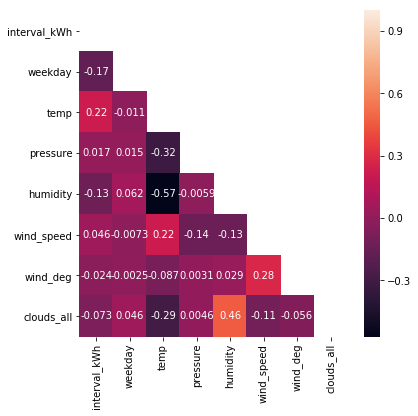

In [26]:
plt.figure(figsize=(6,6))
corrs = hours_wed_corr.corr()
mask = np.triu(np.ones_like(corrs, dtype=np.bool))
sns.heatmap(corrs, mask=mask, annot = True)

## Model: weather data

In [27]:
y = hours_wed_corr['interval_kWh']
X = hours_wed_corr[['temp', 'pressure', 'humidity', 'wind_speed']]
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           interval_kWh   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 1.308e+05
Date:                Fri, 10 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:22:54   Log-Likelihood:                -32724.
No. Observations:               18113   AIC:                         6.546e+04
Df Residuals:                   18109   BIC:                         6.549e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.0526      0.002     21.307      0.000       0.048       0.057
pressure      -0.0068      0.001     -9.444      0.000      -0.008      -0.005
humidity      -0.0037      0.001     -4.919      0.000      -0.005      -0.002
wind_speed     0.0021      0.008      0.252      0.801      -0.014       0.018
==============================================================================
Omnibus:                     1408.002   Durbin-Watson:                   0.505
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7120.832
Skew:                           0.191   Prob(JB):                         0.00
Kurtosis:                       6.048   Cond. No.                         791.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
y = hours_wed_corr['interval_kWh']
X = hours_wed_corr[['temp', 'pressure', 'humidity']]
model_new = sm.OLS(y, X).fit()
model_new.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           interval_kWh   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 1.744e+05
Date:                Fri, 10 Sep 2021   Prob (F-statistic):               0.00
Time:                        17:22:58   Log-Likelihood:                -32724.
No. Observations:               18113   AIC:                         6.545e+04
Df Residuals:                   18110   BIC:                         6.548e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
temp           0.0527      0.002     21.769      0.000       0.048       0.057
pressure      -0.0069      0.001     -9.626      0.000      -0.008      -0.005
humidity      -0.0037      0.001     -4.925      0.000      -0.005      -0.002
==============================================================================
Omnibus:                     1406.259   Durbin-Watson:                   0.505
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7100.298
Skew:                           0.191   Prob(JB):                         0.00
Kurtosis:                       6.043   Cond. No.                         247.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


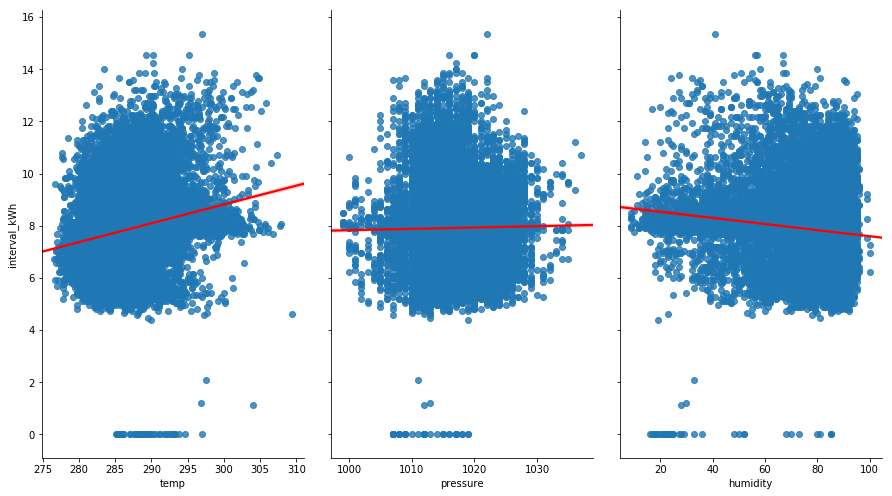

In [29]:
sns.pairplot(hours_wed_corr, x_vars = ['temp', 'pressure', 'humidity'], 
             y_vars = ['interval_kWh'], size=7, aspect=0.6, kind='reg',
            plot_kws={'line_kws':{'color':'red'}})

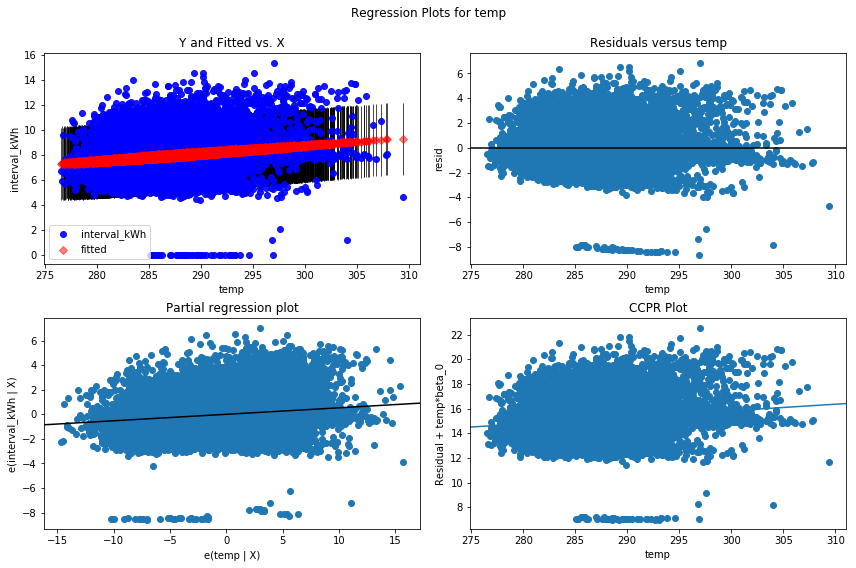

In [30]:
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model_new, 'temp', fig=fig)

In [31]:
# Model training and testing
y = hours_wed_corr['interval_kWh']
X = hours_wed_corr[['temp', 'pressure', 'humidity']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                    test_size=0.25, random_state=123)

In [121]:
lr = LinearRegression()
lr_mod = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_predt = lr.predict(X_train)
mean_absolute_error(y_train, y_predt), mean_squared_error(y_train, y_predt),mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)

(1.0282747616079035, 2.1355600476419134, 1.0344003525766776, 2.150031606439792)

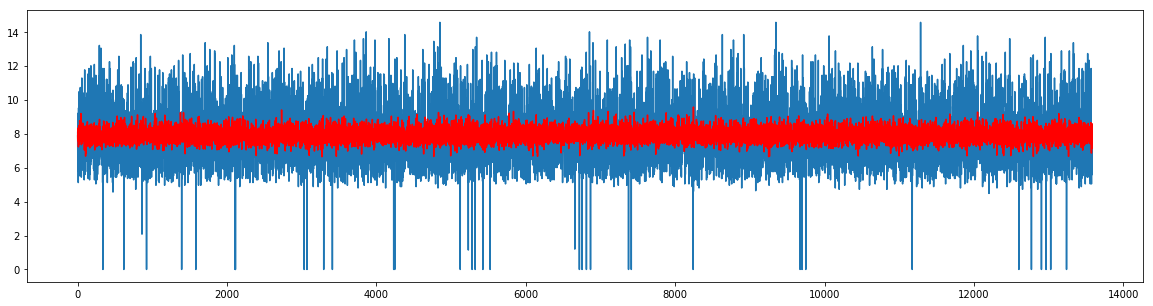

In [140]:
# plot
plt.figure(figsize=(20, 5))

plt.plot(np.array(y_train))
plt.plot(y_predt, color = 'red')

## Model: adding sunlight hours

In [66]:
hours_wed_corr = hours_wed_corr.reset_index(drop=True)

In [68]:
hours_wed_corr['sunrise'] = 0
hours_wed_corr['sunset'] = 0

def data_sunrise(date):
    url = 'https://api.sunrise-sunset.org/json?lat=37.97192&lng=-122.51619&date={}'.format(date)
    info = requests.get(url)
    new = json.loads(info.text)
    return new['results']['sunrise']

def data_sunset(date):
    url = 'https://api.sunrise-sunset.org/json?lat=37.97192&lng=-122.51619&date={}'.format(date)
    info = requests.get(url)
    new = json.loads(info.text)
    return new['results']['sunset']

for i in range(len(hours_wed_corr)):

    
    hours_wed_corr['sunrise'][i]= data_sunrise(hours_wed_corr['date'][i].date())
    hours_wed_corr['sunset'][i]= data_sunset(hours_wed_corr['date'][i].date())


C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [75]:
hours_wed_corr['sunrise'] = pd.to_datetime(hours_wed_corr['sunrise'])
hours_wed_corr['sunset'] = pd.to_datetime(hours_wed_corr['sunset'])

In [93]:
# convert utc to pst
hours_wed_corr['sunrise_pst'] = pd.to_datetime(hours_wed_corr['sunrise'] - pd.Timedelta(hours=7)).dt.time
hours_wed_corr['sunset_pst'] = pd.to_datetime(hours_wed_corr['sunset'] - pd.Timedelta(hours=7)).dt.time

In [96]:
hours_wed_corr.to_csv('data_weather_sunhour.csv')

In [113]:
hours_wed_corr.columns

Index(['index', 'timestamp', 'date', 'hour', 'interval_kWh', 'weekday', 'temp',
       'pressure', 'humidity', 'wind_speed', 'wind_deg', 'clouds_all',
       'weather_main', 'weather_description', 'sunrise', 'sunset',
       'sunrise_pst', 'sunset_pst'],
      dtype='object')

In [114]:
#put df into memory space as db
conn = sqlite3.connect(':memory:')
#write the tables
hours_wed_corr.to_sql('data', conn, index=False)

C:\Users\szhang\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\io\sql.py:460: UserWarning: the 'timedelta' type is not supported, and will be written as integer values (ns frequency) to the database.
  chunksize=chunksize, dtype=dtype, method=method)


In [117]:
# using SQL to create new column faster
qry = '''
select 
timestamp,interval_kWh, weekday, temp,
       pressure, humidity, wind_speed, wind_deg, 
       clouds_all, weather_main, weather_description, 
       sunrise_pst, sunset_pst, 
CASE
when time(timestamp) > time(sunrise_pst) and time(timestamp) < time(sunset_pst) THEN "Yes"
else "No"
END as Sunlight
from data

'''
hours_weather = pd.read_sql_query(qry, conn)

In [119]:
# export to csv
hours_weather.to_csv('df_weather_sun.csv')

In [2]:
hours_weather = pd.read_csv('df_weather_sun.csv')

In [3]:
hours_weather.head()

,Unnamed: 0,timestamp,interval_kWh,weekday,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,weather_description,sunrise_pst,sunset_pst,Sunlight
0,0,2019-07-30 01:00:00,7.84,1.0,294.50,1013,58,2.68,41,1,Clear,sky is clear,06:10:09.000000,20:22:53.000000,No
1,1,2019-07-30 02:00:00,7.76,1.0,292.22,1012,71,0.00,0,1,Clear,sky is clear,06:10:09.000000,20:22:53.000000,No
2,2,2019-07-30 03:00:00,7.84,1.0,291.20,1013,74,2.68,307,1,Clear,sky is clear,06:10:09.000000,20:22:53.000000,No
3,3,2019-07-30 04:00:00,7.76,1.0,290.29,1013,70,1.79,297,1,Clear,sky is clear,06:10:09.000000,20:22:53.000000,No
4,4,2019-07-30 05:00:00,7.92,1.0,289.02,1013,76,0.45,345,1,Clear,sky is clear,06:10:09.000000,20:22:53.000000,No


In [6]:
sunlight = pd.get_dummies(hours_weather.Sunlight, prefix = 'sunlight')
model_prep = hours_weather.join([sunlight])

In [7]:
model_prep.head()

,Unnamed: 0,timestamp,interval_kWh,weekday,temp,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_main,weather_description,sunrise_pst,sunset_pst,Sunlight,sunlight_No,sunlight_Yes
0,0,2019-07-30 01:00:00,7.84,1.0,294.50,1013,58,2.68,41,1,Clear,sky is clear,06:10:09.000000,20:22:53.000000,No,1,0
1,1,2019-07-30 02:00:00,7.76,1.0,292.22,1012,71,0.00,0,1,Clear,sky is clear,06:10:09.000000,20:22:53.000000,No,1,0
2,2,2019-07-30 03:00:00,7.84,1.0,291.20,1013,74,2.68,307,1,Clear,sky is clear,06:10:09.000000,20:22:53.000000,No,1,0
3,3,2019-07-30 04:00:00,7.76,1.0,290.29,1013,70,1.79,297,1,Clear,sky is clear,06:10:09.000000,20:22:53.000000,No,1,0
4,4,2019-07-30 05:00:00,7.92,1.0,289.02,1013,76,0.45,345,1,Clear,sky is clear,06:10:09.000000,20:22:53.000000,No,1,0


In [9]:
# Modeling
y = model_prep['interval_kWh']
X = model_prep[['temp', 'pressure', 'humidity', 
                'sunlight_No', 'sunlight_Yes']]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                    test_size=0.25, random_state=123)
lr = LinearRegression()
lr_mod = lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_predt = lr.predict(X_train)
mean_absolute_error(y_train, y_predt), mean_squared_error(y_train, y_predt),mean_absolute_error(y_test, y_pred), mean_squared_error(y_test, y_pred)

(1.0220751782005277, 2.131766677106162, 1.0266915792283078, 2.142265114751293)

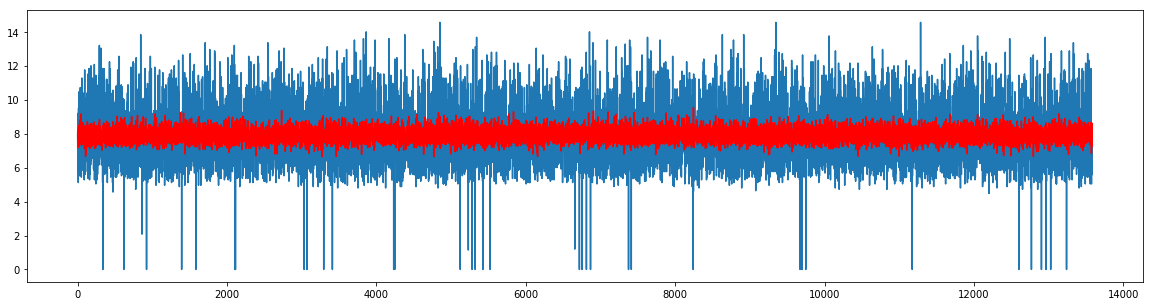

In [10]:
plt.figure(figsize=(20, 5))

plt.plot(np.array(y_train))
plt.plot(y_predt, color = 'red')